# Imports

In [ ]:
pip install symlens

In [ ]:
!pip install git+https://github.com/msyriac/orphics

In [ ]:
pip install pixell

In [ ]:
pip install pyfisher

In [ ]:
!git clone https://github.com/amaurea/enlib

In [ ]:
pip install healpy

In [ ]:
import healpy as hp
from pixell import enmap, utils, curvedsky, enplot, reproject
import numpy as np
import os
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from orphics import maps, cosmology
import tensorflow as tf
import numpy as np
from keras import Sequential
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from pixell.enmap import ndmap
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from orphics import maps as omaps,io,catalogs as cats,stats,cosmology as cosmo
from orphics import maps
import orphics
import pixell
import scipy
from sklearn.model_selection import train_test_split

In [ ]:
data_dir = '/content/drive/MyDrive/websky/'

## Define Directory

In [ ]:
websky_dir = "/content/drive/My Drive/websky/"
websky_path = lambda x: os.path.join(websky_dir, x)
shape, wcs = enmap.fullsky_geometry(res=1*utils.arcmin)

# Load Websky Simulations (from Database)

## Helper Function

In [ ]:
def scale(data):
  return (data - np.min(data))/(np.max(data) - np.min(data))

## Choose CMB Data

In [ ]:
# Load Target Maps (for CMB/CMB+tSZ+kSZ)
kappa_maps = np.load(data_dir + 'kap256.npy')
y = scale(kappa_maps[:50000])
del kappa_maps
y_train, y_test = train_test_split(y, test_size=0.1, random_state=0, shuffle=True)
del y

In [ ]:
# Load CMB
cmb_maps = np.load(data_dir + 'cmb256.npy')
X_pure = scale(cmb_maps) 
del cmb_maps
X_train_pure, X_test_pure = train_test_split(X_pure, test_size=0.1, random_state=0, shuffle=True)
del X_pure

In [ ]:
# Load CMB+tSZ+kSZ
noised_maps = np.load(data_dir + 'noised256.npy')
X_noised = scale(noised_maps)
del noised_maps
X_train_noised, X_test_noised = train_test_split(X_noised, test_size=0.1, random_state=0, shuffle=True)
del X_noised

In [ ]:
# Load CMB+tSZ+kSZ+Instrumentation
noised_maps_5uk = np.load(data_dir + 'cmb_noise_5uk.npy')
X_noised_5uk = scale(noised_maps_5uk)
del noised_maps_5uk
X_train_noised_5uk, X_test_noised_5uk = train_test_split(X_noised_5uk, test_size=0.1, random_state=0, shuffle=True)
del X_noised_5uk

In [ ]:
# Load Uncentered CMB and Kappa
uncentered_cmb_maps = np.load(data_dir + 'cmb_uncentered256.npy')
X_uncentered = scale(uncentered_cmb_maps) 
del uncentered_cmb_maps
X_train_uncentered, X_test_uncentered = train_test_split(X_uncentered, test_size=0.1, random_state=0, shuffle=True)
del X_uncentered

uncentered_kappa_maps = np.load(data_dir + 'kap_uncentered256.npy')
y_uncentered = scale(uncentered_kappa_maps)
del uncentered_kappa_maps
y_train_uncentered, y_test_uncentered = train_test_split(y_uncentered, test_size=0.1, random_state=0, shuffle=True)
del y_uncentered

# Define Generator Architecture (for cGAN and ResUNet)

In [ ]:
# Encoder Block
def encoder(layer_in, n_filters, batchnorm=True):
	init = RandomNormal(stddev=0.02)
	g1 = Conv2D(n_filters, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	g1 = LeakyReLU(alpha=0.2)(g1)
	g2 = Conv2D(n_filters, (3,3), strides=(1,1), padding='same', kernel_initializer=init)(g1)
	g2 = LeakyReLU(alpha=0.2)(g1)
	
	if batchnorm:
		g2 = BatchNormalization()(g2, training=True)
	
	return g2
 
# Decoder Block
def decoder(layer_in, skip_in, n_filters, dropout=True):
	init = RandomNormal(stddev=0.02)
	g1 = Conv2DTranspose(n_filters, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	g1 = LeakyReLU(alpha=0.2)(g1)
	g2 = Conv2D(n_filters, (3,3), strides=(1,1), padding='same', kernel_initializer=init)(g2)
	g2 = LeakyReLU(alpha=0.2)(g2)
	g2 = BatchNormalization()(g2, training=True)
	
	if dropout:
		g2 = Dropout(0.5)(g2, training=True)
	
	# Establish Skip Connections
	g2 = Concatenate()([g2, skip_in])
	g2 = Activation('relu')(g2)
	return g2
 
# Generator Architecture (to be used for cGAN and ResUNet)
def generator(image_shape=(128,128,1)):
	init = RandomNormal(stddev=0.02)
 
	# Encoding sequence
	e1 = encoder(Input(shape=image_shape), 32, batchnorm=False)
	e2 = encoder(e1, 64)
	e3 = encoder(e2, 128)
	e4 = encoder(e3, 256)
	e5 = encoder(e4, 512)
	e6 = encoder(e5, 1024)
 
	# Bottleneck Sequence
	b = Conv2D(2048, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(e6)
	b = LeakyReLU(alpha=0.2)(b)
	b = Conv2D(1024, (3,3), strides=(1,1), padding='same', kernel_initializer=init)(b)
	b = LeakyReLU(alpha=0.2)(b)
 
	# Decoding Sequence
	d2 = decoder(b, e6, 1024, dropout=True)
	d3 = decoder(d2, e5, 512, dropout=True)
	d4 = decoder(d3, e4, 256, dropout=False)
	d5 = decoder(d4, e3, 128, dropout=False)
	d6 = decoder(d5, e2, 64, dropout=False)
	d7 = decoder(d6, e1, 32, dropout=False)
 
	# Final Sequence
	g = Conv2DTranspose(1, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	g = Activation('tanh')(g)
	
	# Define model
	model = Model(Input(shape=image_shape), g)
	return model

# Define the rest of cGAN

## Define Discriminator

In [ ]:
def discriminator(image_shape=(128,128,1)):
	init = RandomNormal(stddev=0.02)
 
  # Input K and K_pred
	pred = Input(shape=image_shape)
	truth = Input(shape=image_shape)
 
  # Define Discriminator Sequence
	d1 = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(Concatenate()([pred, truth]))
	d1 = LeakyReLU(alpha=0.2)(d1)
	d2 = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d1)
	d2 = BatchNormalization()(d2)
	d2 = LeakyReLU(alpha=0.2)(d2)
	d3 = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d2)
	d3 = BatchNormalization()(d3)
	d3 = LeakyReLU(alpha=0.2)(d3)
	d4 = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d3)
	d4 = BatchNormalization()(d4)
	d4 = LeakyReLU(alpha=0.2)(d4)
	d5 = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d4)
	d5 = BatchNormalization()(d5)
	d5 = LeakyReLU(alpha=0.2)(d5)
	d6 = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d5)
	d6 = Activation('sigmoid')(d6)
	model = Model([pred, truth], d6)
 
  # Compile Model
	model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
 
	return model

## Define GAN

In [ ]:
# Borrowed from Brownlee (2021)
def cgan(g_model, d_model, image_shape):
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	in_src = Input(shape=image_shape)
	gen_out = g_model(in_src)
	dis_out = d_model([in_src, gen_out])
	model = Model(in_src, [dis_out, gen_out])
	opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model

## Generate real and fake samples

In [ ]:
# Borrowed from Brownlee (2021)
def generate_real_samples(X_train_pure, y_train, n_samples, patch_shape):
	trainA, trainB = X_train_pure, y_train
	ix = np.random.randint(0, trainA.shape[0], n_samples)
	X1, X2 = trainA[ix], trainB[ix]
	y = np.ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y
 
def generate_fake_samples(g_model, samples, patch_shape):
	X = g_model.predict(samples)
	y = np.zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

## Train

In [ ]:
# Borrowed from Brownlee (2021)
def train(d_model, g_model, gan_model, X_train_pure, y_train, n_epochs=100, n_batch=32):
	n_patch = d_model.output_shape[1]
	trainA, trainB = X_train_pure, y_train
	bat_per_epo = int(len(trainA) / n_batch)
	n_steps = bat_per_epo * n_epochs
	for i in range(n_steps):
		[X_realA, X_realB], y_real = generate_real_samples(X_train_pure, y_train, n_batch, n_patch)
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		if (i+1)%10 == 0:
			print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))

# Train ResUNet

In [ ]:
def custom_loss(y_true, y_pred):
    return K.mean((y_true - y_pred)**2)

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=0.000001, verbose=1)
model_checkpoint = ModelCheckpoint("./keras.model", save_best_only=True, verbose=1)

In [ ]:
resunet = define_generator()
resunet.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.0002), 
             loss=custom_loss)

In [ ]:
import time
start = time.time()

history = resunet.fit(X_train_pure, y_train, batch_size=32, epochs=100, validation_split=0.1, callbacks = [reduce_lr, model_checkpoint])

end = time.time()
print(end-start)

In [ ]:
from keras.models import load_model
resunet = load_model("./keras.model", compile=False)
resunet.save(data_dir + 'resunet_uncentered')

# Train cGAN

In [ ]:
X_train_pure = X_train_uncentered.reshape((X_train_uncentered.shape[0], 128, 128, 1))
y_train = y_train_uncentered.reshape((y_train_uncentered.shape[0], 128, 128, 1))

In [ ]:
import time
start = time.time()

image_shape = X_train_pure.shape[1:]
d_model = discriminator(image_shape)
g_model = generator(image_shape)
gan_model = cgan(g_model, d_model, image_shape)
train(d_model, g_model, gan_model, X_train_pure, y_train)

end = time.time()
print(end - start)

# Compare Performance

## Load Models

In [ ]:
resunet_pure = tf.keras.models.load_model(data_dir + 'resunet_pure')
pix2pix_pure = tf.keras.models.load_model(data_dir + 'pix2pix_pure')
resunet_noised = tf.keras.models.load_model(data_dir + 'resunet_noised')
pix2pix_noised = tf.keras.models.load_model(data_dir + 'pix2pix_noised')
resunet_5uk = tf.keras.models.load_model(data_dir + 'resunet_noised_5uk', compile = False)
pix2pix_5uk = tf.keras.models.load_model(data_dir + 'pix2pix_noised_5uk', compile = False)
pix2pix_uncentered = tf.keras.models.load_model(data_dir + 'pix2pix_uncentered', compile = False)
resunet_uncentered = tf.keras.models.load_model(data_dir + 'resunet_uncentered', compile = False)

## Load Testing Data

In [ ]:
def scale(data):
  return (data - np.min(data))/(np.max(data) - np.min(data))

In [ ]:
# Load Target Maps (for CMB/CMB+tSZ+kSZ)
kappa_maps = np.load(data_dir + 'kap256.npy')
y = scale(kappa_maps[:50000])
del kappa_maps
y_train, y_test = train_test_split(y, test_size=0.1, random_state=0, shuffle=True)
del y, y_train

In [ ]:
# Load CMB
cmb_maps = np.load(data_dir + 'cmb256.npy')
X_pure = scale(cmb_maps[:50000]) 
del cmb_maps
X_train_pure, X_test_pure = train_test_split(X_pure, test_size=0.1, random_state=0, shuffle=True)
del X_pure, X_train_pure

In [ ]:
# Load CMB+tSZ+kSZ
noised_maps = np.load(data_dir + 'noised256.npy')
X_noised = scale(noised_maps)
del noised_maps
X_train_noised, X_test_noised = train_test_split(X_noised, test_size=0.1, random_state=0, shuffle=True)
del X_noised, X_train_noised

In [ ]:
# Load CMB+tSZ+kSZ+Instrumentation
noised_maps_5uk = np.load(data_dir + 'noised_5uk256.npy')
X_noised_5uk = scale(noised_maps_5uk)
del noised_maps_5uk
X_train_noised_5uk, X_test_noised_5uk = train_test_split(X_noised_5uk, test_size=0.1, random_state=0, shuffle=True)
del X_noised_5uk, X_train_noised_5uk

In [ ]:
# Load Uncentered CMB and Kappa
uncentered_cmb_maps = np.load(data_dir + 'cmb_uncentered256.npy')
X_uncentered = scale(uncentered_cmb_maps) 
del uncentered_cmb_maps
X_train_uncentered, X_test_uncentered = train_test_split(X_uncentered, test_size=0.1, random_state=0, shuffle=True)
del X_uncentered, X_train_uncentered

uncentered_kappa_maps = np.load(data_dir + 'kap_uncentered256.npy')
y_uncentered = scale(uncentered_kappa_maps)
del uncentered_kappa_maps
y_train_uncentered, y_test_uncentered = train_test_split(y_uncentered, test_size=0.1, random_state=0, shuffle=True)
del y_uncentered, y_train_uncentered

## Make Predictions

In [ ]:
# Make Predictions
y_pred_rpure = resunet_pure.predict(X_test_pure)[:, :, :, 0]
y_pred_ppure = pix2pix_pure.predict(X_test_pure)[:, :, :, 0]

y_pred_rnoised = resunet_noised.predict(X_test_noised)[:, :, :, 0]
y_pred_pnoised = pix2pix_noised.predict(X_test_noised)[:, :, :, 0]

y_pred_r5uk = resunet_5uk.predict(X_test_noised_5uk)[:, :, :, 0]
y_pred_p5uk = pix2pix_5uk.predict(X_test_noised_5uk)[:, :, :, 0]

y_pred_runcentered = resunet_uncentered.predict(X_test_uncentered)[:,:,:,0]
y_pred_puncentered = pix2pix_uncentered.predict(X_test_uncentered)[:,:,:,0]

## Visualizations

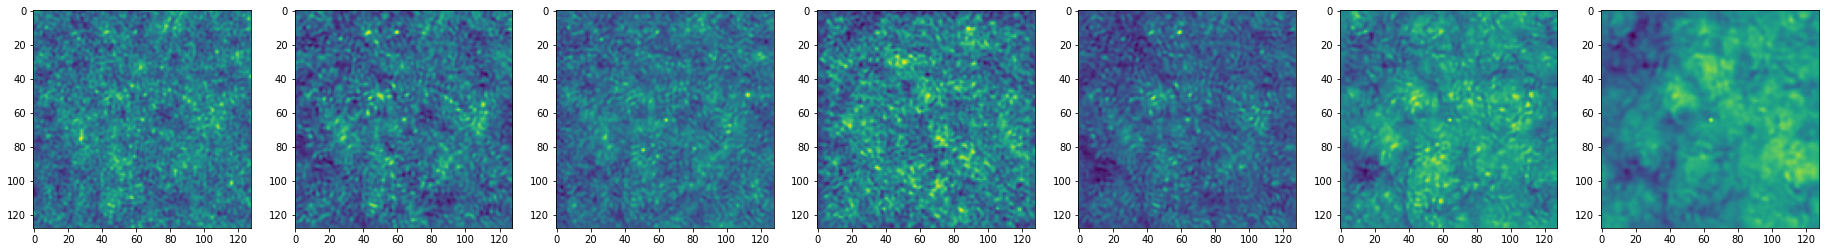

In [ ]:
fig, ax = plt.subplots(1, 7, figsize = (32,32))

idx = 4758
ax[0].imshow(y_test[idx])

ax[1].imshow(y_pred_ppure[idx])
ax[2].imshow(y_pred_pnoised[idx])
ax[3].imshow(y_pred_p5uk[idx])
ax[4].imshow(y_pred_rpure[idx])
ax[5].imshow(y_pred_rnoised[idx])
ax[6].imshow(y_pred_r5uk[idx])

In [ ]:
fig, ax = plt.subplots(1, 7, figsize = (32,32))

idx = 4758
ax[0].imshow(y_test_uncentered[idx])

ax[1].imshow(y_pred_puncentered[idx])
ax[2].imshow(y_pred_runcentered[idx])

## Generate Power Spectra


In [ ]:
# Define ell bins
bins = 30

# Define number of bootstrap folds
folds = 5000
size = int(5000/folds)

# Define Geometry
oshape, owcs = maps.rect_geometry(width_arcmin=128, px_res_arcmin=1)

# Define Bin Edges
bin_edges = np.linspace(100, 7000, bins)

# Taper kappa maps at edges to avoid problems
taper, w2 = maps.get_taper(oshape, owcs)

lbin, _ = maps.binned_power(ndmap(y_pred_ppure[0, :, :], owcs), bin_edges=bin_edges)

clbin_pred_rpure = np.zeros((folds,bins-1))
clbin_pred_ppure = np.zeros((folds,bins-1))

clbin_pred_pnoised = np.zeros((folds,bins-1))
clbin_pred_rnoised = np.zeros((folds,bins-1))

clbin_pred_p5uk = np.zeros((folds,bins-1))
clbin_pred_r5uk = np.zeros((folds,bins-1))

clbin_pred_puncentered = np.zeros((folds,bins-1))
clbin_pred_runcentered = np.zeros((folds,bins-1))

clbin_test = np.zeros((folds,bins-1))

# Bootstrap Through folds
for i in range(folds):
  rpure_i = y_pred_rpure[i*size:(i+1)*size]
  ppure_i = y_pred_ppure[i*size:(i+1)*size]

  rnoised_i = y_pred_rnoised[i*size:(i+1)*size]
  pnoised_i = y_pred_pnoised[i*size:(i+1)*size]

  r5uk_i = y_pred_r5uk[i*size:(i+1)*size]
  p5uk_i = y_pred_p5uk[i*size:(i+1)*size]

  runcentered_i = y_pred_runcentered[i*size:(i+1)*size]
  puncentered_i = y_pred_puncentered[i*size:(i+1)*size]

  test_i = y_test[i*size:(i+1)*size]

  # Iterate through each bootstrap fold
  for j in range(size):
    map_pred_rpure = ndmap(rpure_i[j, :, :], owcs)*taper
    map_pred_ppure = ndmap(ppure_i[j, :, :], owcs)*taper

    map_pred_rnoised = ndmap(rnoised_i[j, :, :], owcs)*taper
    map_pred_pnoised = ndmap(pnoised_i[j, :, :], owcs)*taper

    map_pred_r5uk = ndmap(r5uk_i[j, :, :], owcs)*taper
    map_pred_p5uk = ndmap(p5uk_i[j, :, :], owcs)*taper

    map_pred_runcentered = ndmap(runcentered_i[j, :, :], owcs)*taper
    map_pred_puncentered = ndmap(puncentered_i[j, :, :], owcs)*taper

    map_test = ndmap(test_i[j, :, :], owcs)*taper

    # Bin power spectrum using orphics package for each type of input and for test
    clbin_pred_rpure[i,:] += maps.binned_power(map_pred_rpure, bin_edges=bin_edges)[1]
    clbin_pred_ppure[i,:] += maps.binned_power(map_pred_ppure, bin_edges=bin_edges)[1]
  
    clbin_pred_rnoised[i,:] += maps.binned_power(map_pred_rnoised, bin_edges=bin_edges)[1]
    clbin_pred_pnoised[i,:] += maps.binned_power(map_pred_pnoised, bin_edges=bin_edges)[1]
  
    clbin_pred_r5uk[i,:] += maps.binned_power(map_pred_r5uk, bin_edges=bin_edges)[1]
    clbin_pred_p5uk[i,:] += maps.binned_power(map_pred_p5uk, bin_edges=bin_edges)[1]

    clbin_pred_runcentered[i,:] += maps.binned_power(map_pred_runcentered, bin_edges=bin_edges)[1]
    clbin_pred_puncentered[i,:] += maps.binned_power(map_pred_puncentered, bin_edges=bin_edges)[1]
  
    clbin_test[i,:] += maps.binned_power(map_test, bin_edges=bin_edges)[1]

  # Normalize
  clbin_pred_rpure[i,:] /= size
  clbin_pred_ppure[i,:] /= size

  clbin_pred_rnoised[i,:] /= size
  clbin_pred_pnoised[i,:] /= size

  clbin_pred_r5uk[i,:] /= size
  clbin_pred_p5uk[i,:] /= size

  clbin_pred_runcentered[i,:] /= size
  clbin_pred_puncentered[i,:] /= size

  clbin_test[i,:] /= size

In [ ]:
# Average Power Spectra across 50 folds
clbin_rpure_avg = np.average(clbin_pred_rpure,axis=0)
clbin_ppure_avg = np.average(clbin_pred_ppure,axis=0)
clbin_rnoised_avg = np.average(clbin_pred_rnoised,axis=0)
clbin_pnoised_avg = np.average(clbin_pred_pnoised,axis=0)
clbin_r5uk_avg = np.average(clbin_pred_r5uk,axis=0)
clbin_p5uk_avg = np.average(clbin_pred_p5uk,axis=0)
clbin_runcentered_avg = np.average(clbin_pred_runcentered,axis=0)
clbin_puncentered_avg = np.average(clbin_pred_puncentered,axis=0)
clbin_test_avg = np.average(clbin_test,axis=0)

In [ ]:
# Averaged standard deviation / power spectra per bin
rpure_avgs = np.std(clbin_pred_rpure,axis=0)/np.average(clbin_pred_rpure,axis=0)
ppure_avgs = np.std(clbin_pred_ppure,axis=0)/np.average(clbin_pred_ppure,axis=0)
rnoised_avgs = np.std(clbin_pred_rnoised,axis=0)/np.average(clbin_pred_rnoised,axis=0)
pnoised_avgs = np.std(clbin_pred_pnoised,axis=0)/np.average(clbin_pred_pnoised,axis=0)
r5uk_avgs = np.std(clbin_pred_r5uk,axis=0)/np.average(clbin_pred_r5uk,axis=0)
p5uk_avgs = np.std(clbin_pred_p5uk,axis=0)/np.average(clbin_pred_p5uk,axis=0)
runcentered_avgs = np.std(clbin_pred_runcentered,axis=0)/np.average(clbin_pred_runcentered,axis=0)
puncentered_avgs = np.std(clbin_pred_puncentered,axis=0)/np.average(clbin_pred_puncentered,axis=0)

In [ ]:
# Print average standard deviation / average power spectra
print(np.average(rpure_avgs))
print(np.average(ppure_avgs))
print(np.average(rnoised_avgs))
print(np.average(pnoised_avgs))
print(np.average(r5uk_avgs))
print(np.average(p5uk_avgs))
print(np.average(runcentered_avgs))
print(np.average(puncentered_avgs))

0.12817730124136587
0.13024013023484984
0.13098069067748774
0.12496085196288388
0.12307765381714166
0.11753452421817587
0.12788876697336177
0.12450354386784046


Text(0.5, 1.0, 'Power Spectra, Off-Centered')

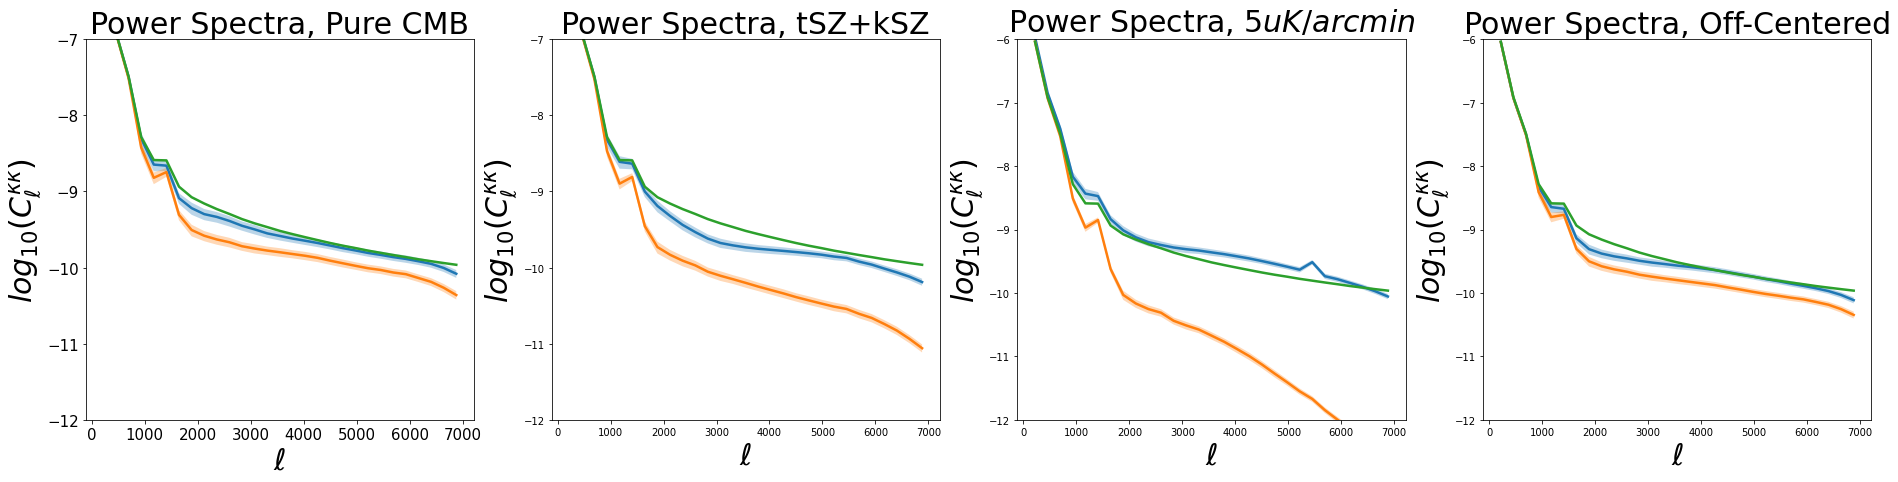

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(32,7))

ax[0].plot(lbin, np.log10(clbin_ppure_avg), label='Pix2Pix, $\hat{\kappa}$', linewidth=2.5)
ax[0].fill_between(lbin, np.log10(clbin_ppure_avg*(1-ppure_avgs)), np.log10(clbin_ppure_avg*(1+ppure_avgs)), alpha=0.3)
ax[0].plot(lbin, np.log10(clbin_rpure_avg), label='ResUNet, $\hat{\kappa}$', linewidth=2.5)
ax[0].fill_between(lbin, np.log10(clbin_rpure_avg*(1-rpure_avgs)), np.log10(clbin_rpure_avg*(1+rpure_avgs)), alpha=0.3)
ax[0].plot(lbin, np.log10(clbin_test_avg), label='Ground Truth, $\kappa$', linewidth=2.5)
ax[0].set_ylabel(r"$log_{10}(C_{\ell}^{\kappa \kappa})$", fontsize=30)
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[0].set_ylim(-12, -7)
ax[0].set_xlabel(r"$\ell$", fontsize=30)
ax[0].set_title(r"Power Spectra, Pure CMB", fontsize=30)

ax[1].plot(lbin, np.log10(clbin_pnoised_avg), label='Pix2Pix, $\hat{\kappa}$', linewidth=2.5)
ax[1].fill_between(lbin, np.log10(clbin_pnoised_avg*(1-pnoised_avgs)), np.log10(clbin_pnoised_avg*(1+pnoised_avgs)), alpha=0.3)
ax[1].plot(lbin, np.log10(clbin_rnoised_avg), label='ResUNet, $\hat{\kappa}$', linewidth=2.5)
ax[1].fill_between(lbin, np.log10(clbin_rnoised_avg*(1-rnoised_avgs)), np.log10(clbin_rnoised_avg*(1+rnoised_avgs)), alpha=0.3)
ax[1].plot(lbin, np.log10(clbin_test_avg), label='Ground Truth, $\kappa$', linewidth=2.5)
ax[1].set_ylabel(r"$log_{10}(C_{\ell}^{\kappa \kappa})$", fontsize=30)
ax[1].set_ylim(-12, -7)
ax[1].set_xlabel(r"$\ell$", fontsize=30)
ax[1].set_title(r"Power Spectra, tSZ+kSZ", fontsize=30)

ax[2].plot(lbin, np.log10(clbin_p5uk_avg), label='cGAN, $\hat{\kappa}$', linewidth=2.5)
ax[2].fill_between(lbin, np.log10(clbin_p5uk_avg*(1-p5uk_avgs)), np.log10(clbin_p5uk_avg*(1+p5uk_avgs)), alpha=0.3)
ax[2].plot(lbin, np.log10(clbin_r5uk_avg), label='ResUNet, $\hat{\kappa}$', linewidth=2.5)
ax[2].fill_between(lbin, np.log10(clbin_r5uk_avg*(1-r5uk_avgs)), np.log10(clbin_r5uk_avg*(1+r5uk_avgs)), alpha=0.3)
ax[2].plot(lbin, np.log10(clbin_test_avg), label='Ground Truth, $\kappa$', linewidth=2.5)
ax[2].set_ylabel(r"$log_{10}(C_{\ell}^{\kappa \kappa})$", fontsize=30)
ax[2].set_ylim(-12, -6)
ax[2].set_xlabel(r"$\ell$", fontsize=30)
ax[2].set_title(r"Power Spectra, $5uK/arcmin$", fontsize=30)

ax[3].plot(lbin, np.log10(clbin_puncentered_avg), label='cGAN, $\hat{\kappa}$', linewidth=2.5)
ax[3].fill_between(lbin, np.log10(clbin_puncentered_avg*(1-puncentered_avgs)), np.log10(clbin_puncentered_avg*(1+puncentered_avgs)), alpha=0.3)
ax[3].plot(lbin, np.log10(clbin_runcentered_avg), label='ResUNet, $\hat{\kappa}$', linewidth=2.5)
ax[3].fill_between(lbin, np.log10(clbin_runcentered_avg*(1-runcentered_avgs)), np.log10(clbin_runcentered_avg*(1+runcentered_avgs)), alpha=0.3)
ax[3].plot(lbin, np.log10(clbin_test_avg), label='Ground Truth, $\kappa$', linewidth=2.5)
ax[3].set_ylabel(r"$log_{10}(C_{\ell}^{\kappa \kappa})$", fontsize=30)
ax[3].set_ylim(-12, -6)
ax[3].set_xlabel(r"$\ell$", fontsize=30)
ax[3].set_title(r"Power Spectra, Off-Centered", fontsize=30)

## Generate 1-Point PDFs

In [ ]:
bins_ppure, counts_ppure = np.histogram(y_pred_ppure.flatten(), np.arange(0, 1, 0.01), density=True)
bins_rpure, counts_rpure = np.histogram(y_pred_rpure.flatten(), np.arange(0, 1, 0.01), density=True)
bins_pnoised, counts_pnoised = np.histogram(y_pred_pnoised.flatten(), np.arange(0, 1, 0.01), density=True)
bins_rnoised, counts_rnoised = np.histogram(y_pred_rnoised.flatten(), np.arange(0, 1, 0.01), density=True)
bins_p5uk, counts_p5uk = np.histogram(y_pred_p5uk.flatten(), np.arange(0, 1, 0.01), density=True)
bins_r5uk, counts_r5uk = np.histogram(y_pred_r5uk.flatten(), np.arange(0, 1, 0.01), density=True)
bins_puncentered, counts_puncentered = np.histogram(y_pred_puncentered.flatten(), np.arange(0, 1, 0.01), density=True)
bins_runcentered, counts_runcentered = np.histogram(y_pred_runcentered.flatten(), np.arange(0, 1, 0.01), density=True)

bins2, counts2 = np.histogram(y_test.flatten(), np.arange(0, 1, 0.01), density=True)

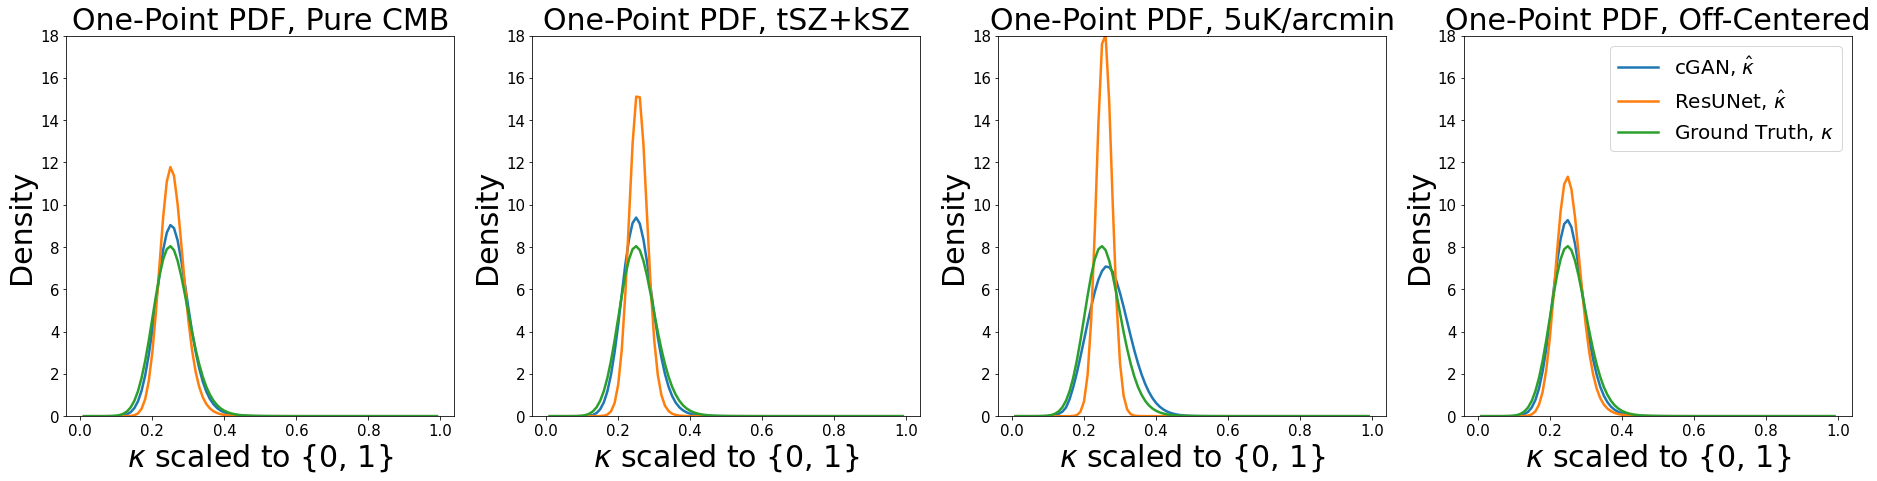

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(32,7))

ax[0].plot(counts_ppure[1:], bins_ppure, label='Pix2Pix, $\hat{\kappa}$', linewidth=2.5)
ax[0].plot(counts_rpure[1:], bins_rpure, label='ResUNet, $\hat{\kappa}$', linewidth=2.5)
ax[0].plot(counts2[1:], bins2, label='Ground Truth, $\kappa$', linewidth=2.5)
ax[0].set_xlabel('$\kappa$ scaled to {0, 1}', fontsize=30)
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[0].set_ylabel('Density', fontsize=30)
ax[0].set_ylim(0,18)
ax[0].set_title('One-Point PDF, Pure CMB', fontsize=30)

ax[1].plot(counts_pnoised[1:], bins_pnoised, label='Pix2Pix, $\hat{\kappa}$', linewidth=2.5)
ax[1].plot(counts_rnoised[1:], bins_rnoised, label='ResUNet, $\hat{\kappa}$', linewidth=2.5)
ax[1].plot(counts2[1:], bins2, label='Ground Truth, $\kappa$', linewidth=2.5)
ax[1].set_xlabel('$\kappa$ scaled to {0, 1}', fontsize=30)
ax[1].set_ylabel('Density', fontsize=30)
ax[1].set_ylim(0,18)
ax[1].set_title('One-Point PDF, tSZ+kSZ', fontsize=30)
ax[1].tick_params(axis='both', which='major', labelsize=15)

ax[2].plot(counts_p5uk[1:], bins_p5uk, label='cGAN, $\hat{\kappa}$', linewidth=2.5)
ax[2].plot(counts_r5uk[1:], bins_r5uk, label='ResUNet, $\hat{\kappa}$', linewidth=2.5)
ax[2].plot(counts2[1:], bins2, label='Ground Truth, $\kappa$', linewidth=2.5)
ax[2].set_xlabel('$\kappa$ scaled to {0, 1}', fontsize=30)
ax[2].set_ylabel('Density', fontsize=30)
ax[2].set_title('One-Point PDF, 5uK/arcmin', fontsize=30)
ax[2].set_ylim(0,18)
ax[2].tick_params(axis='both', which='major', labelsize=15)

ax[3].plot(counts_puncentered[1:], bins_puncentered, label='cGAN, $\hat{\kappa}$', linewidth=2.5)
ax[3].plot(counts_runcentered[1:], bins_runcentered, label='ResUNet, $\hat{\kappa}$', linewidth=2.5)
ax[3].plot(counts2[1:], bins2, label='Ground Truth, $\kappa$', linewidth=2.5)
ax[3].set_xlabel('$\kappa$ scaled to {0, 1}', fontsize=30)
ax[3].set_ylabel('Density', fontsize=30)
ax[3].set_title('One-Point PDF, Off-Centered', fontsize=30)
ax[3].tick_params(axis='both', which='major', labelsize=15)
ax[3].set_ylim(0,18)
ax[3].legend(fontsize=20)